In [52]:
# ======= Step 0:  =======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,recall_score
from sklearn.preprocessing import StandardScaler

# ======= Step 1:=======

data = pd.read_csv("../10_Data_Clean/final_data.csv")
# Step 2: Filter only FIRE_EXPOSED = 1 

fire_exposed_data = data[data['FIRE_EXPOSED'] == 1].copy()

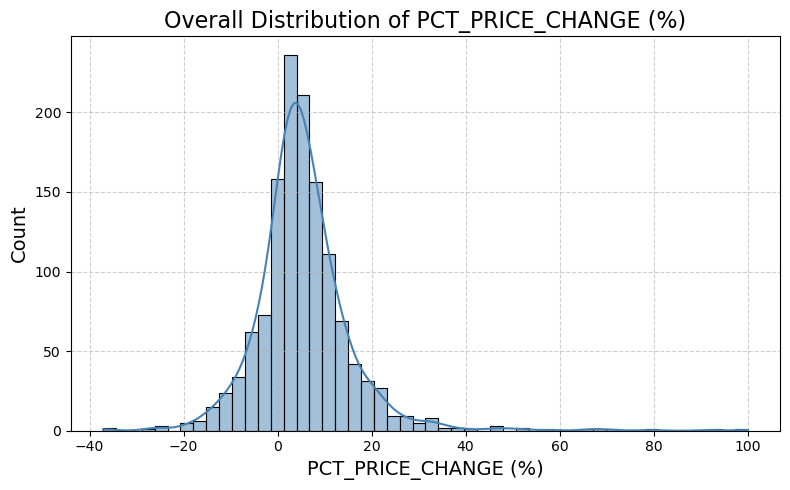

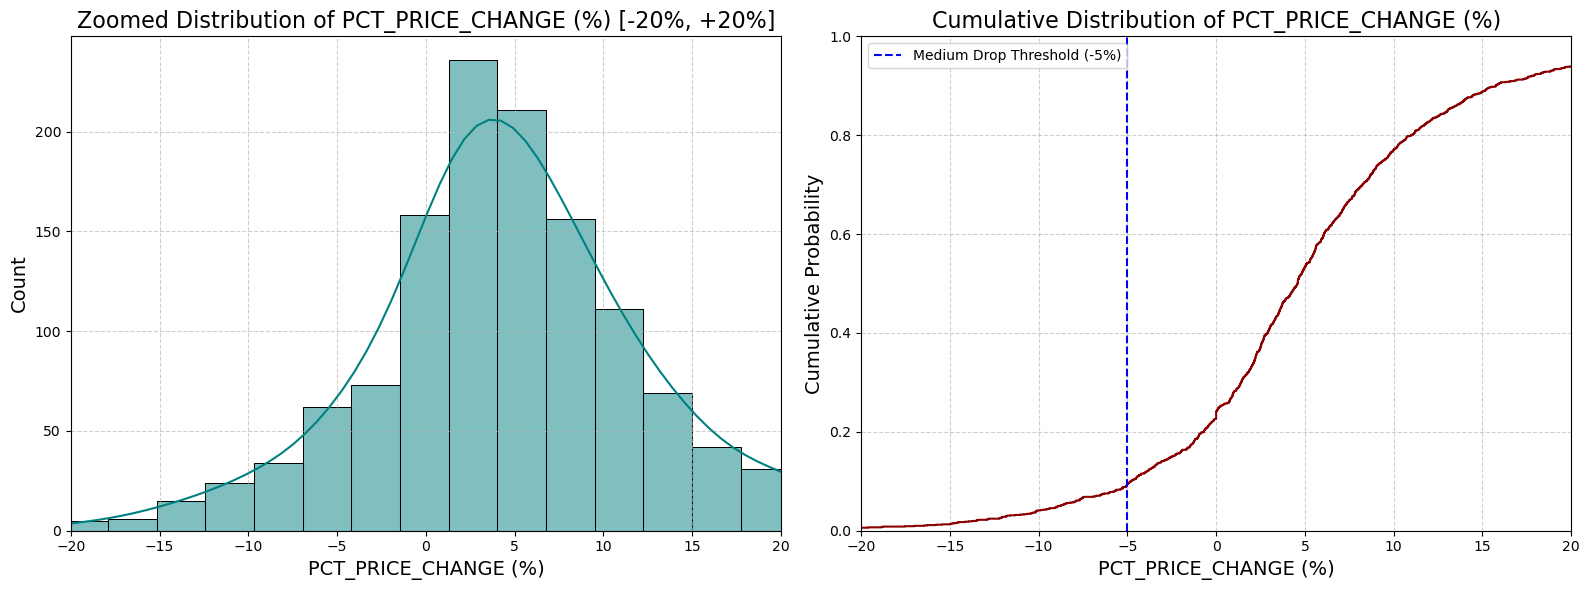

In [53]:
# Step 3: EDA - Overall Distribution
plt.figure(figsize=(8,5))
sns.histplot(fire_exposed_data['PCT_PRICE_CHANGE (%)'], bins=50, kde=True, color='steelblue')

plt.title('Overall Distribution of PCT_PRICE_CHANGE (%)', fontsize=16)
plt.xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step 4: EDA - Zoomed Distribution and CDF
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Left Plot: Zoomed-in Histogram
sns.histplot(
    fire_exposed_data['PCT_PRICE_CHANGE (%)'],
    bins=50,
    kde=True,
    color='teal',
    ax=axes[0]
)
axes[0].set_xlim(-20, 20)
axes[0].set_title('Zoomed Distribution of PCT_PRICE_CHANGE (%) [-20%, +20%]', fontsize=16)
axes[0].set_xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right Plot: Cumulative Distribution (CDF)
sns.ecdfplot(
    fire_exposed_data['PCT_PRICE_CHANGE (%)'],
    color='darkred',
    ax=axes[1]
)
axes[1].set_title('Cumulative Distribution of PCT_PRICE_CHANGE (%)', fontsize=16)
axes[1].set_xlabel('PCT_PRICE_CHANGE (%)', fontsize=14)
axes[1].set_ylabel('Cumulative Probability', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Mark -5% thresholds on CDF
axes[1].axvline(x=-5, color='blue', linestyle='--', label='Medium Drop Threshold (-5%)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [54]:
def assign_damage_severity(pct_change):
    if pct_change >= -5:
        return 0  # Small Drop
    else:
        return 1  # Severe Drop


# Apply function
fire_exposed_data['DAMAGE_SEVERITY_CLASS'] = fire_exposed_data['PCT_PRICE_CHANGE (%)'].apply(assign_damage_severity)


/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_22798/2397440392.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='DAMAGE_SEVERITY_CLASS', data=fire_exposed_data, palette='Set2')


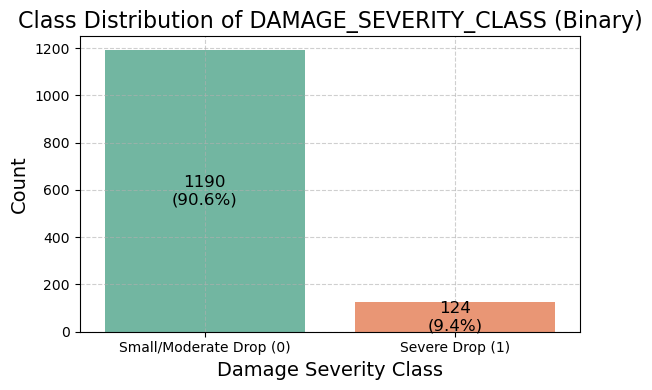

In [55]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='DAMAGE_SEVERITY_CLASS', data=fire_exposed_data, palette='Set2')

plt.title('Class Distribution of DAMAGE_SEVERITY_CLASS (Binary)', fontsize=16)
plt.xlabel('Damage Severity Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([0, 1], ['Small/Moderate Drop (0)', 'Severe Drop (1)'])  


counts = fire_exposed_data['DAMAGE_SEVERITY_CLASS'].value_counts().sort_index()
percentages = fire_exposed_data['DAMAGE_SEVERITY_CLASS'].value_counts(normalize=True).sort_index()


for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(i, count/2, f'{count}\n({pct:.1%})', ha='center', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [56]:
baseline_feature_cols = [
    'Median_Household_Income',
    'Total_Population',
    'Avg_Household_Size',
    'Gini_Index',
    'Employment_Rate',
    'Below_Poverty_Rate',
    'Rate_College_or_Higher',
    'Black_Portion',
    'White_Portion',
    'American_Indian_and_Alaska_Native_Portion',
    'Asian_Portion',
    'YEARS_SINCE_LAST_FIRE',
    'CUMULATIVE_AREA_BURNED_LAST_2YRS',
    'PREV_MAX_PCT_TRACT_BURNED',        
    'ROLLING_2yr_PRICE_CHANGE_STD' 
]



TRAIN_YEAR_CUTOFF = 2017

train_df = fire_exposed_data[fire_exposed_data['YEAR'] <= TRAIN_YEAR_CUTOFF]
test_df = fire_exposed_data[fire_exposed_data['YEAR'] > TRAIN_YEAR_CUTOFF]

X_train = train_df[baseline_feature_cols]
y_train = train_df['DAMAGE_SEVERITY_CLASS']

X_test = test_df[baseline_feature_cols]
y_test = test_df['DAMAGE_SEVERITY_CLASS']



In [57]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,recall_score

# === Step 1: Baseline Naive Majority Classifier ===
majority_clf = DummyClassifier(strategy='most_frequent') 
majority_clf.fit(X_train, y_train)

# === Step 2: Predict on Test Set ===
y_pred_baseline = majority_clf.predict(X_test)

# === Step 3: Evaluate ===
print("=== Baseline Majority Classifier Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_baseline, average='macro'):.4f}")
print(f"Recall (Severe Drop class): {recall_score(y_test, y_pred_baseline, pos_label=1):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Small Drop (0)', 'Severe Drop (2)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))


=== Baseline Majority Classifier Performance ===
Accuracy: 0.9652
Macro F1 Score: 0.4911
Recall (Severe Drop class): 0.0000

Classification Report:
                 precision    recall  f1-score   support

 Small Drop (0)       0.97      1.00      0.98       665
Severe Drop (2)       0.00      0.00      0.00        24

       accuracy                           0.97       689
      macro avg       0.48      0.50      0.49       689
   weighted avg       0.93      0.97      0.95       689


Confusion Matrix:
[[665   0]
 [ 24   0]]


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [65]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

# Define binary XGBoost Classifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',  # binary!
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Sample weights
sample_weights = y_train.map(class_weight_dict)

# Fit
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)

Class Weights: {0: 0.5952380952380952, 1: 3.125}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

=== XGBoost Model Performance (Binary Classification) ===
Accuracy: 0.9637


Macro F1 Score: 0.5278
Recall (Severe Drop class): 0.0417

Classification Report:
                         precision    recall  f1-score   support

Small/Moderate Drop (0)       0.97      1.00      0.98       665
        Severe Drop (1)       0.33      0.04      0.07        24

               accuracy                           0.96       689
              macro avg       0.65      0.52      0.53       689
           weighted avg       0.94      0.96      0.95       689


Confusion Matrix:


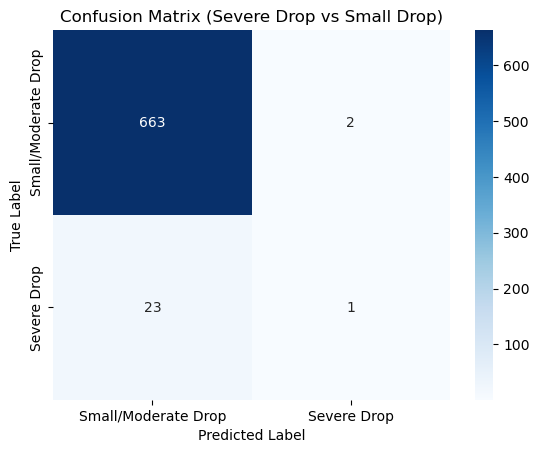

In [59]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluation
print("=== XGBoost Model Performance (Binary Classification) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"Recall (Severe Drop class): {recall_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Small/Moderate Drop (0)', 'Severe Drop (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Small/Moderate Drop', 'Severe Drop'], yticklabels=['Small/Moderate Drop', 'Severe Drop'])
plt.title('Confusion Matrix (Severe Drop vs Small Drop)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

=== XGBoost Model Performance (Adjusted Threshold 0.3) ===
Accuracy: 0.9550
Macro F1 Score: 0.5695
Recall (Severe Drop class): 0.1250

Classification Report:
                         precision    recall  f1-score   support

Small/Moderate Drop (0)       0.97      0.98      0.98       665
        Severe Drop (1)       0.23      0.12      0.16        24

               accuracy                           0.96       689
              macro avg       0.60      0.55      0.57       689
           weighted avg       0.94      0.96      0.95       689


Confusion Matrix:


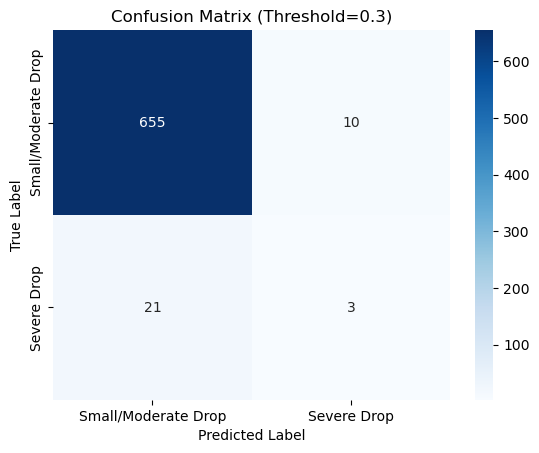

In [60]:
# Predict Probabilities
y_pred_prob = xgb_clf.predict_proba(X_test)[:, 1]

# Adjust Threshold
threshold = 0.3
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# Evaluation
print(f"=== XGBoost Model Performance (Adjusted Threshold {threshold}) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_adjusted, average='macro'):.4f}")
print(f"Recall (Severe Drop class): {recall_score(y_test, y_pred_adjusted, pos_label=1):.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Small/Moderate Drop (0)', 'Severe Drop (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Small/Moderate Drop', 'Severe Drop'], yticklabels=['Small/Moderate Drop', 'Severe Drop'])
plt.title(f'Confusion Matrix (Threshold={threshold})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [61]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

xgb_clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [62]:
thresholds = np.arange(0.1, 0.5, 0.05)

for threshold in thresholds:
    y_pred_thresh = (y_pred_prob >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    macro_f1 = f1_score(y_test, y_pred_thresh, average='macro')
    print(f"Threshold: {threshold:.2f} | Recall: {recall:.4f} | Macro F1: {macro_f1:.4f}")


Threshold: 0.10 | Recall: 0.3333 | Macro F1: 0.5304
Threshold: 0.15 | Recall: 0.2500 | Macro F1: 0.5488
Threshold: 0.20 | Recall: 0.1250 | Macro F1: 0.5295
Threshold: 0.25 | Recall: 0.1250 | Macro F1: 0.5520
Threshold: 0.30 | Recall: 0.1250 | Macro F1: 0.5695
Threshold: 0.35 | Recall: 0.1250 | Macro F1: 0.5778
Threshold: 0.40 | Recall: 0.0417 | Macro F1: 0.5229
Threshold: 0.45 | Recall: 0.0417 | Macro F1: 0.5261


The ability to distinguish the minority class is still insufficient. However, the threshold adjustment is close to the limit.

In [64]:
# Rebuild model with scale_pos_weight
from xgboost import XGBClassifier

# redefine scale_pos_weight
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

xgb_clf_weighted = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Train without sample_weight
xgb_clf_weighted.fit(X_train, y_train)

# Predict
y_pred_prob_weighted = xgb_clf_weighted.predict_proba(X_test)[:, 1]

# Grid search again on thresholds
thresholds = np.arange(0.1, 0.5, 0.05)
for threshold in thresholds:
    y_pred_thresh = (y_pred_prob_weighted >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_thresh, pos_label=1)
    macro_f1 = f1_score(y_test, y_pred_thresh, average='macro')
    print(f"Threshold: {threshold:.2f} | Recall: {recall:.4f} | Macro F1: {macro_f1:.4f}")


Scale_pos_weight: 5.25
Threshold: 0.10 | Recall: 0.2917 | Macro F1: 0.5352
Threshold: 0.15 | Recall: 0.2083 | Macro F1: 0.5404
Threshold: 0.20 | Recall: 0.1667 | Macro F1: 0.5603
Threshold: 0.25 | Recall: 0.1667 | Macro F1: 0.5941
Threshold: 0.30 | Recall: 0.0833 | Macro F1: 0.5477
Threshold: 0.35 | Recall: 0.0833 | Macro F1: 0.5498
Threshold: 0.40 | Recall: 0.0833 | Macro F1: 0.5570
Threshold: 0.45 | Recall: 0.0833 | Macro F1: 0.5597


In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
import numpy as np

# Define scale_pos_weight search range
scale_pos_weights = [1, 2, 3, 4, 5]

# Store results
results = []

for spw in scale_pos_weights:
    print(f"\n=== Training with scale_pos_weight={spw} ===")
    
    xgb_clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=spw,
        random_state=42
    )
    
    xgb_clf.fit(X_train, y_train)
    
    y_pred_prob = xgb_clf.predict_proba(X_test)[:, 1]
    
    threshold = 0.3
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    recall = recall_score(y_test, y_pred, pos_label=1)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall (Severe Drop class): {recall:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    
    results.append((spw, acc, recall, macro_f1))

print("\n=== Summary: ===")
print("scale_pos_weight\tAccuracy\tRecall\tMacro F1")
for spw, acc, recall, macro_f1 in results:
    print(f"{spw}\t\t\t{acc:.4f}\t\t{recall:.4f}\t{macro_f1:.4f}")



=== Training with scale_pos_weight=1 ===
Accuracy: 0.9637
Recall (Severe Drop class): 0.0833
Macro F1 Score: 0.5597

=== Training with scale_pos_weight=2 ===
Accuracy: 0.9608
Recall (Severe Drop class): 0.0833
Macro F1 Score: 0.5545

=== Training with scale_pos_weight=3 ===
Accuracy: 0.9579
Recall (Severe Drop class): 0.0417
Macro F1 Score: 0.5215

=== Training with scale_pos_weight=4 ===
Accuracy: 0.9579
Recall (Severe Drop class): 0.1250
Macro F1 Score: 0.5749

=== Training with scale_pos_weight=5 ===
Accuracy: 0.9579
Recall (Severe Drop class): 0.1250
Macro F1 Score: 0.5749

=== Summary: ===
scale_pos_weight	Accuracy	Recall	Macro F1
1			0.9637		0.0833	0.5597
2			0.9608		0.0833	0.5545
3			0.9579		0.0417	0.5215
4			0.9579		0.1250	0.5749
5			0.9579		0.1250	0.5749


In [67]:
thresholds = [0.2, 0.25, 0.3, 0.35]

for threshold in thresholds:
    y_pred_adjusted = (y_pred_prob >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_adjusted, pos_label=1)
    macro_f1 = f1_score(y_test, y_pred_adjusted, average='macro')
    print(f"Threshold: {threshold:.2f} | Recall: {recall:.4f} | Macro F1: {macro_f1:.4f}")


Threshold: 0.20 | Recall: 0.2083 | Macro F1: 0.5874
Threshold: 0.25 | Recall: 0.2083 | Macro F1: 0.6039
Threshold: 0.30 | Recall: 0.1250 | Macro F1: 0.5749
Threshold: 0.35 | Recall: 0.0833 | Macro F1: 0.5521


### summary above test for  threshold  & scale_pos_weight

=== Final Model Performance (scale_pos_weight=4, threshold=0.25) ===
Accuracy: 0.9521
Macro F1 Score: 0.6039
Recall (Severe Drop class): 0.2083

Classification Report:
                         precision    recall  f1-score   support

Small/Moderate Drop (0)       0.97      0.98      0.98       665
        Severe Drop (1)       0.26      0.21      0.23        24

               accuracy                           0.95       689
              macro avg       0.62      0.59      0.60       689
           weighted avg       0.95      0.95      0.95       689



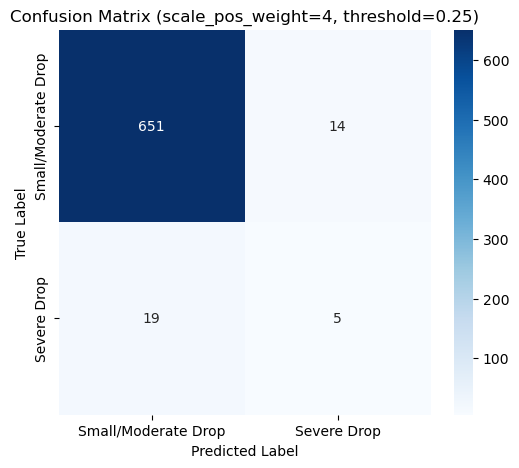

In [69]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

threshold_best = 0.25
y_pred_best = (y_pred_prob >= threshold_best).astype(int)

accuracy = accuracy_score(y_test, y_pred_best)
macro_f1 = f1_score(y_test, y_pred_best, average='macro')
recall = recall_score(y_test, y_pred_best, pos_label=1)

print(f"=== Final Model Performance (scale_pos_weight=4, threshold={threshold_best}) ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Recall (Severe Drop class): {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Small/Moderate Drop (0)', 'Severe Drop (1)']))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Small/Moderate Drop', 'Severe Drop'], yticklabels=['Small/Moderate Drop', 'Severe Drop'])
plt.title(f'Confusion Matrix (scale_pos_weight=4, threshold={threshold_best})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### lightgbm


[LightGBM] [Info] Number of positive: 100, number of negative: 525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 625, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160000 -> initscore=-1.658228
[LightGBM] [Info] Start training from score -1.658228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

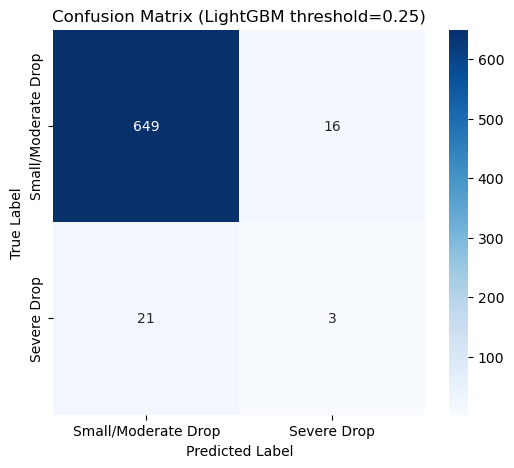

In [70]:
# === 1. Import Libraries ===
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === 2. Prepare Data ===

# === 3. Initialize LightGBM Model ===
lgbm_clf = LGBMClassifier(
    objective='binary',       
    is_unbalance=True,         
    learning_rate=0.1,          
    n_estimators=100,         
    max_depth=5,               
    subsample=0.8,             
    colsample_bytree=0.8,       
    random_state=42
)

# === 4. Train Model ===
lgbm_clf.fit(X_train, y_train)

# === 5. Predict Probabilities ===
y_pred_prob = lgbm_clf.predict_proba(X_test)[:, 1]

# === 6. Adjust Threshold ===
threshold = 0.25  #
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# === 7. Evaluate Performance ===
accuracy = accuracy_score(y_test, y_pred_adjusted)
macro_f1 = f1_score(y_test, y_pred_adjusted, average='macro')
recall = recall_score(y_test, y_pred_adjusted, pos_label=1)

print(f"=== Final LightGBM Model Performance (threshold={threshold}) ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Recall (Severe Drop class): {recall:.4f}")

# === 8. Detailed Classification Report ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Small/Moderate Drop (0)', 'Severe Drop (1)']))


